# Comparing with `matlab` Baselines

This code is ported from `matlab` scripts.
Before adding features, we tested a variety of simulations to ensure answers are close (typically within round-off) of the `matlab` solutions.

First we ran a test case with 9 columns and analytic forcing fields, that can be run with `matlab_script = 'test_case'`.
Next we read in forcing for three locations from netCDF files; that test can be run with `matlab_script = 'test_locs3'`.
Finally, we read in forcing from the CESM FOSI run.
For exact reproduction, that test can be run with `matlab_script = 'FOSI_cesm_daily'`.

## Additional Improvements

After verifying we could reproduce the `matlab` solutions with daily forcing, we then added the ability to interpolate from monthly forcing.
We also modified how the interpolation is done:

1. We kept the dates from the CESM FOSI simulation, rather than assuming the output was evenly spaced 30 days apart each year
1. We apply a floor of 0 for the zooplankton mortality, rather than using the minimum value over the calendar year
1. We do not extrapolate prior to the first level or after the last time level; instead, we use the first or last level, respectively.

Due to these changes, running `matlab_script = 'FOSI_cesm'` will not be within round-off of the `matlab` runs.
Similarly, `matlab_script = 'FOSI_cesm_spinup'` uses cyclic forcing from the first year but with the above changes to interpolation so the resulting initial conditions will not match the `matlab` output.

## Running the model

Setup a `feisty` integration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster
from utils import compare_nc, default_config, old_settings

import feisty

## Configure run

There are a few options on how to run:

1. `test_case` uses an idealized testcase where forcing and depth are computed analytically
1. `test_locs3` is a simple model where three columns were pulled from a larger run for quick testing
1. `FOSI_spinup` cycles through the first year of 68 years of forcing generated from a CESM; its purpose is to provide equilibriated initial conditions
1. `FOSI_cesm` uses initial conditions from `FOSI_spinup` but the full 68 years of forcing from CESM to allow biomass to evolve

Note that both of the `FOSI` options run on the 85813 active ocean cells from the POP `gx1v7` grid.

In [3]:
# matlab_script = 'test_case'
matlab_script = 'test_locs3'
# matlab_script = 'FOSI_spinup'
# matlab_script = 'FOSI_cesm'

In [4]:
# Configuration settings for the offline driver as well as output generated in this notebook
driver_config = default_config()

# configurations that differ from default
driver_config['test_case']['ignore_year_in_forcing'] = True
driver_config['test_case']['make_err_plots'] = True
driver_config['test_case']['plot_settings']['ylim'] = [1e-6, 1]

driver_config['test_locs3']['ignore_year_in_forcing'] = True
driver_config['test_locs3']['end_date'] = '0002-12-31'
driver_config['test_locs3']['max_output_time_dim'] = 730
driver_config['test_locs3']['make_err_plots'] = True
driver_config['test_locs3']['plot_settings']['ylim'] = [1e-6, 100]

driver_config['FOSI_spinup']['ignore_year_in_forcing'] = True
driver_config['FOSI_cesm']['end_date'] = '0251-12-31'
driver_config['FOSI_spinup']['end_date'] = '0100-12-31'
for matlab_script_loc in ['FOSI_cesm', 'FOSI_cesm_daily', 'FOSI_spinup']:
    driver_config[matlab_script_loc]['num_chunks'] = 18
    driver_config[matlab_script_loc]['baseline'] = 'FOSI_cesm.nc'
    driver_config[matlab_script_loc]['baseline_compare'] = False
    if matlab_script_loc != 'FOSI_spinup':
        driver_config[matlab_script_loc]['start_date'] = '0249-01-01'
        driver_config[matlab_script_loc]['make_err_plots'] = True
    driver_config[matlab_script_loc]['compare_forcing'] = False
    # diagnostic_names=driver_config[matlab_script_loc]['diagnostic_names'] = ['growth_rate']
    driver_config[matlab_script_loc]['plot_settings']['X'] = 55000  # looks good
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 15633  # large error in small classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 11677  # large error in medium classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 76989  # large error in benthic

for matlab_script_loc in ['test_case', 'test_locs3']:
    driver_config[matlab_script_loc]['settings_in'] = old_settings()

In [5]:
baselines_from_nc = xr.open_dataset(
    f'../matlab_baselines/{driver_config[matlab_script]["baseline"]}'
)

# Set negative forcing values to zero
if driver_config[matlab_script]['force_nonnegative']:
    for var in ['poc_flux_bottom', 'zooC', 'zoo_mort']:
        baselines_from_nc[var].data = np.where(
            baselines_from_nc[var].data > 0, baselines_from_nc[var].data, 0
        )

if matlab_script not in driver_config:
    raise ValueError(f"unknown matlab_script '{matlab_script}'")

## Set up Dask cluster (if chunking data)



In [6]:
if driver_config[matlab_script]['num_chunks'] > 1:
    ncores = np.minimum(driver_config[matlab_script]['num_chunks'], 36)
    dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})
    # dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
    # dask.config.set({"distributed.comm.timeouts.connect": "180s"})
    cluster = PBSCluster(
        memory='300 GB',
        processes=ncores,
        cores=ncores,
        queue='casper',
        walltime='1:00:00',
        resource_spec='select=1:ncpus=36:mem=300GB',
    )

    cluster.scale(1)
    client = Client(cluster)
else:
    client = None
client

## Run the model

In [7]:
%%time

print(f'Configuring and running {matlab_script}...')

if matlab_script == 'test_case':
    ds_out = feisty.config_and_run_testcase(
        'tanh_shelf',
        'cyclic',
        end_date=driver_config[matlab_script]['end_date'],
        settings_in=driver_config[matlab_script]['settings_in'],
        max_output_time_dim=driver_config[matlab_script]['max_output_time_dim'],
    )
else:
    ds_out = feisty.config_and_run_from_netcdf(
        './forcing.yaml',
        matlab_script,
        start_date=driver_config[matlab_script]['start_date'],
        end_date=driver_config[matlab_script]['end_date'],
        ignore_year_in_forcing=driver_config[matlab_script]['ignore_year_in_forcing'],
        settings_in=driver_config[matlab_script]['settings_in'],
        diagnostic_names=driver_config[matlab_script]['diagnostic_names'],
        max_output_time_dim=driver_config[matlab_script]['max_output_time_dim'],
        num_chunks=driver_config[matlab_script]['num_chunks'],
    )

Configuring and running test_locs3...
Starting forcing dataset generation at 09:56:16
Starting template generation at 09:56:16
Starting run() at 09:56:16
Integrating 730 steps (starting at 09:56:16)
Finished _solve at 09:56:35
CPU times: user 18 s, sys: 195 ms, total: 18.2 s
Wall time: 19.2 s


In [8]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(baselines_from_nc, ds_out["biomass"], thres=1e-15)

| group | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| Sf (t=0002-02-09 00:00:00, X=280.5) | 3.0534e-05 | 3.0534e-05 | 2.2193e-16 |
| Sp (t=0001-01-01 00:00:00, X=195.5) | 9.9989e-06 | 9.9989e-06 | 0.0000e+00 |
| Sd (t=0002-12-08 00:00:00, X=202.5) | 8.7526e-06 | 8.7526e-06 | 1.9355e-16 |
| Mf (t=0001-03-03 00:00:00, X=195.5) | 4.1794e-05 | 4.1794e-05 | 3.2427e-16 |
| Mp (t=0001-04-20 00:00:00, X=280.5) | 1.4277e-04 | 1.4277e-04 | 3.7971e-16 |
| Md (t=0001-01-05 00:00:00, X=280.5) | 1.5650e-05 | 1.5650e-05 | 2.1649e-16 |
| Lp (t=0002-03-06 00:00:00, X=280.5) | 9.9276e-04 | 9.9276e-04 | 6.5526e-16 |
| Ld (t=0001-08-03 00:00:00, X=202.5) | 2.0739e-05 | 2.0739e-05 | 1.6337e-15 |
| benthic_prey (t=0002-01-06 00:00:00, X=202.5) | 3.3466e-01 | 3.3466e-01 | 1.9905e-15 |


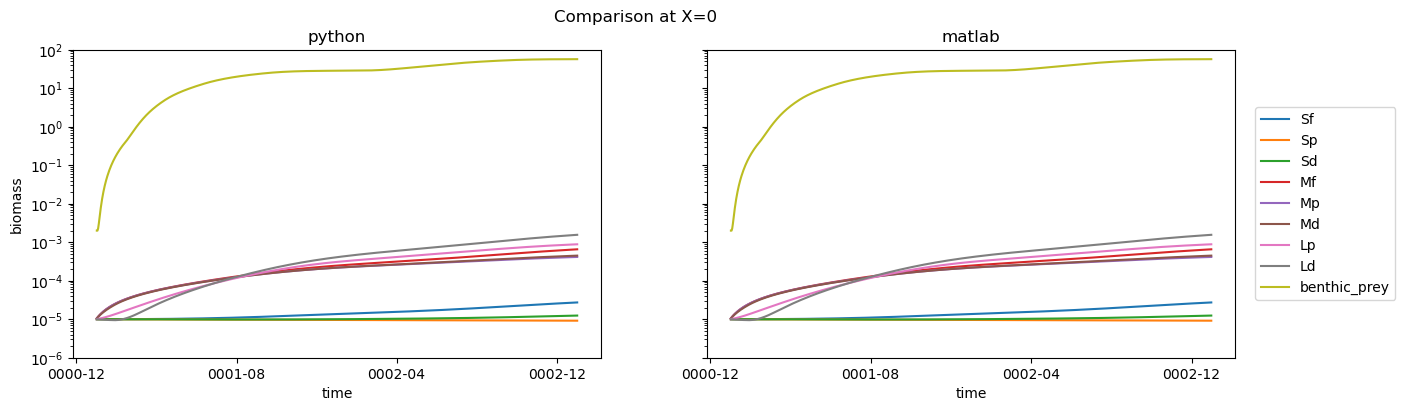

In [9]:
if driver_config[matlab_script]['make_plots']:
    if len(baselines_from_nc.time) > len(ds_out.time):
        isel_dict = {"time": range(len(ds_out.time))}
        baselines_tmp = baselines_from_nc.isel(isel_dict).assign_coords(
            {'group': ds_out.group.data, 'time': ds_out.time.data}
        )
    else:
        baselines_tmp = baselines_from_nc.assign_coords({'group': ds_out.group.data})
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in ds_out.group.data:
        ds_out.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[0])
        baselines_tmp.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[1])
    for ax in axs:
        ax.set_ylim(driver_config[matlab_script]['plot_settings']['ylim'])
        ax.set_yscale("log")
    axs[0].set_title("python")
    axs[1].set_title("matlab")
    axs[1].set_ylabel("")
    axs[1].set_yticklabels("")
    plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    fig.suptitle(f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}")

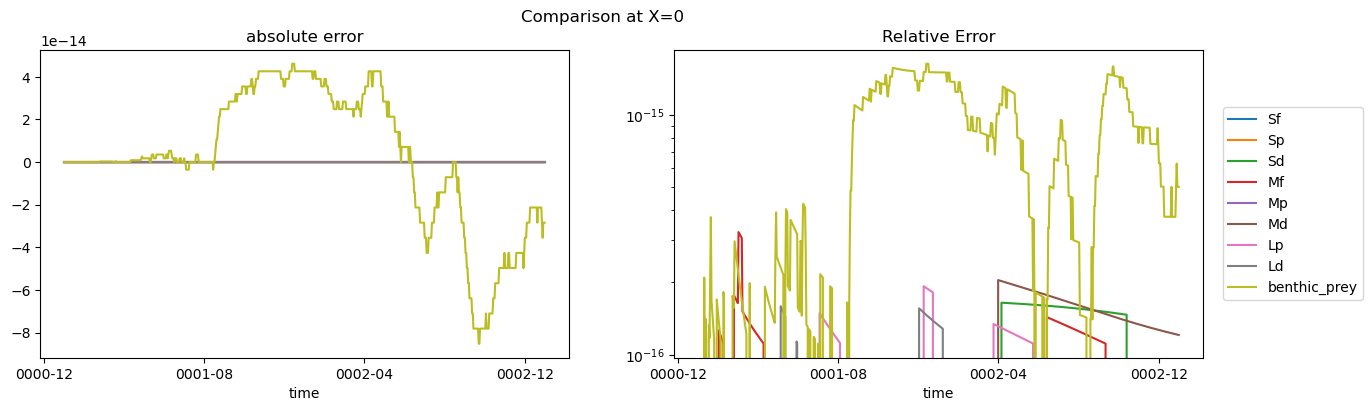

In [10]:
if driver_config[matlab_script]['make_err_plots']:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in ds_out.group.data:
        da1 = ds_out.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        )
        if len(baselines_from_nc.time) < len(ds_out.time):
            da1 = da1.isel({"time": range(len(baselines_from_nc.time))})
        da2 = (
            baselines_tmp.biomass.sel(group=group)
            .isel(X=driver_config[matlab_script]['plot_settings']['X'])
            .assign_coords({'time': da1.time.data})
        )
        (da1 - da2).plot(ax=axs[0])
        (np.abs(da1 - da2) / da2).plot(ax=axs[1])
    axs[0].set_title("absolute error")
    axs[0].set_ylabel("")
    axs[1].set_title("relative error")
    axs[1].set_ylabel("")
    axs[1].set_yscale("log")
    plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    plt.title("Relative Error")
    fig_suptitle = f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}"
    if len(baselines_from_nc.time) < len(ds_out.time):
        fig_suptitle = f"{fig_suptitle} (time dimension reduced from above)"
    fig.suptitle(fig_suptitle)

In [11]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(
        baselines_from_nc.isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        ds_out["biomass"].isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        thres=1e-15,
    )

| group | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| Sf (t=0001-01-01 00:00:00, X=195.5) | 9.9997e-06 | 9.9997e-06 | 0.0000e+00 |
| Sp (t=0001-01-01 00:00:00, X=195.5) | 9.9989e-06 | 9.9989e-06 | 0.0000e+00 |
| Sd (t=0002-04-06 00:00:00, X=195.5) | 1.0285e-05 | 1.0285e-05 | 1.6472e-16 |
| Mf (t=0001-03-03 00:00:00, X=195.5) | 4.1794e-05 | 4.1794e-05 | 3.2427e-16 |
| Mp (t=0001-01-01 00:00:00, X=195.5) | 1.0541e-05 | 1.0541e-05 | 0.0000e+00 |
| Md (t=0002-04-01 00:00:00, X=195.5) | 2.6491e-04 | 2.6491e-04 | 2.0464e-16 |
| Lp (t=0001-12-09 00:00:00, X=195.5) | 2.8092e-04 | 2.8092e-04 | 1.9298e-16 |
| Ld (t=0001-05-06 00:00:00, X=195.5) | 4.2578e-05 | 4.2578e-05 | 1.5915e-16 |
| benthic_prey (t=0001-12-13 00:00:00, X=195.5) | 2.8330e+01 | 2.8330e+01 | 1.6302e-15 |
